Procesamiento de Lenguaje Natural: Hands On
==================

In [1]:
import pandas as pd
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups as news

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction import text

import xgboost as xgb

from nltk import word_tokenize
from nltk.corpus import stopwords

from tqdm import tqdm

seed = 24

news_train = news(subset='train', shuffle=True, random_state=seed)
news_test = news(subset='test', shuffle=True, random_state=seed)

# Vamos a indagar un poco sobre los datos

In [2]:
news_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
len(news_train.data)

11314

In [4]:
print("\n".join(news_train.data[0].split("\n")))

From: HOLFELTZ@LSTC2VM.stortek.com
Subject: Re: Need a book
Organization: StorageTek SW Engineering
Lines: 37

In article <Apr.14.03.08.18.1993.5458@athos.rutgers.edu>
bassili@cs.arizona.edu (Amgad Z. Bassili) writes:
 
>
>I appreciate if anyone can point out some good books about the dead sea
>scrolls of Qumran. Thanks in advance.
>
>Please reply by e-mail at <bassili@cs.arizona.edu>
 
Ok boys & girls, hang on; here we go!
 
   Christ's Eternal Gospel               Robinson & Robinson
   The Dead Sea Scrolls & the NT         WS LaSor
   James the Just in Habakkuk Pesher     RH Eisenman
   Maccabees ... Quamran                 RH Eisenman
   Dead Sea Scrolls Uncovered            Eisenman & Wise
   Dead Sea Scrolls Deception            Baigent & Leigh
   Jesus & Riddle of Dead Sea Scrolls    B Thiering
   Jesus Scroll                          D Joyce
 
Happy Reading & welcome aboard
 
 
A poor Wayfaring Stranger [some say, a Strange One] in a strange land,
 
 +--------------------------

In [5]:
print(news_train.target_names[news_train.target[0]])

soc.religion.christian


In [6]:
df = pd.DataFrame({'content': news_train.data, 'target': news_train.target })
df['dataset'] = 'train'
df = pd.concat([df, pd.DataFrame({'content': news_test.data, 'target': news_test.target })])
df.loc[df.dataset.isnull(), 'dataset'] = 'test'

<AxesSubplot:ylabel='target'>

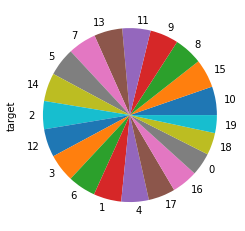

In [7]:
df[df.dataset == 'train'].target.value_counts().plot.pie()

In [8]:
x_train = df[df.dataset == 'train'].content
x_test = df[df.dataset == 'test'].content

y_train = df[df.dataset == 'train'].target
y_test = df[df.dataset == 'test'].target

# Bag of words

In [9]:
count_vect = CountVectorizer(tokenizer=word_tokenize, 
                             stop_words='english',
                             strip_accents='ascii')

x_train_bow = count_vect.fit_transform(df[df.dataset == 'train'].content)
x_train_bow.shape

(11314, 181210)

In [10]:
pd.Series(count_vect.get_feature_names()).sample(5)

135513               pod6f
108278             lc4u-34
143612        religiosidad
30194                 4738
64198     cc.curtin.edu.au
dtype: object

La dimensionalidad es demasiado grande, vamos a intentar reducirla un poco ...

In [12]:
count_vect = CountVectorizer(tokenizer=word_tokenize, 
                             stop_words='english',
                             strip_accents='ascii',
                             token_pattern=r'\[a-zA-Z0-9]{3,}',
                             max_features=1000)

# Construcción de un clasificador utilizando regresión logística

In [13]:
def evaluate_pipeline(model, vectorizer, x_train, x_test, y_train, y_test):
    ''' Create and evaluate pipeline. '''
    if vectorizer:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model),
        ])
    else:
        pipeline = Pipeline([
            ('classifier', model),
        ])

    pipeline.fit(x_train, y_train)
    
    y_pred = pipeline.predict(x_test)

    print(classification_report(y_test, y_pred))
    
    return pipeline

In [14]:
logistic = LogisticRegression(max_iter=1000, 
                              random_state=seed,
                              tol=0.001,
                              n_jobs=-1)

In [15]:
logreg_countv_pl = evaluate_pipeline(logistic, count_vect, 
                                     x_train, x_test, 
                                     y_train, y_test)

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       319
           1       0.48      0.52      0.50       389
           2       0.60      0.54      0.57       394
           3       0.50      0.51      0.51       392
           4       0.59      0.61      0.60       385
           5       0.65      0.57      0.61       395
           6       0.72      0.74      0.73       390
           7       0.62      0.60      0.61       396
           8       0.70      0.78      0.73       398
           9       0.63      0.63      0.63       397
          10       0.76      0.74      0.75       399
          11       0.81      0.73      0.77       396
          12       0.41      0.47      0.44       393
          13       0.59      0.55      0.57       396
          14       0.71      0.72      0.72       394
          15       0.73      0.74      0.74       398
          16       0.60      0.65      0.63       364
          17       0.78    

In [16]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']

pred = logreg_countv_pl.predict(docs_new)

for doc, category in zip(docs_new, pred):
    print('%r => %s' % (doc, news_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.sys.mac.hardware


# Construcción de un clasificador utilizando xgboost

In [17]:
xgbm = xgb.XGBClassifier(max_depth=7, n_estimators=50, colsample_bytree=0.8, 
                         subsample=0.8, nthread=6, learning_rate=0.1, use_label_encoder=False)

logreg_countv_pl = evaluate_pipeline(xgbm, count_vect, x_train, x_test, y_train, y_test)

[20:30:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.59      0.56      0.58       319
           1       0.53      0.56      0.54       389
           2       0.68      0.64      0.66       394
           3       0.52      0.56      0.54       392
           4       0.64      0.62      0.63       385
           5       0.64      0.64      0.64       395
           6       0.80      0.87      0.83       390
           7       0.77      0.68      0.72       396
           8       0.83      0.74      0.78       398
           9       0.67      0.70      0.68       397
          10       0.76      0.76      0.76       399
          11       0.87      0.75      0.81       396
          12  

# Construcción de un clasificador utilizando Naïve Bayes

<img src="http://www.cs.cornell.edu/courses/cs4780/2015fa/web/projects/03NaiveBayes/nb.png" width="300px"/>
<img src="http://uc-r.github.io/public/images/analytics/naive_bayes/naive_bayes_icon.png" width="300px" />

In [18]:
nb = MultinomialNB()

nb_countv_pl = evaluate_pipeline(nb, count_vect, x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.38      0.58      0.46       319
           1       0.39      0.52      0.44       389
           2       0.13      0.01      0.01       394
           3       0.42      0.49      0.46       392
           4       0.44      0.56      0.49       385
           5       0.43      0.33      0.38       395
           6       0.58      0.81      0.68       390
           7       0.41      0.68      0.51       396
           8       0.55      0.63      0.59       398
           9       0.56      0.66      0.61       397
          10       0.86      0.42      0.56       399
          11       0.78      0.71      0.75       396
          12       0.39      0.46      0.42       393
          13       0.60      0.40      0.48       396
          14       0.65      0.64      0.65       394
          15       0.77      0.63      0.69       398
          16       0.42      0.35      0.38       364
          17       0.77    

In [19]:
pred = nb_countv_pl.predict(docs_new)

for doc, category in zip(docs_new, pred):
    print('%r => %s' % (doc, news_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => rec.autos


# TF-IDF

In [20]:
tfv = TfidfVectorizer(min_df=3,  max_features=1000, 
                      strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                      stop_words = 'english')

## Analizamos nuevamente para LR

In [21]:
logistic = LogisticRegression(max_iter=1000, 
                              random_state=seed,
                              tol=0.001,
                              n_jobs=-1)

logreg_tfv_pl = evaluate_pipeline(logistic, tfv, x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       319
           1       0.57      0.64      0.60       389
           2       0.69      0.64      0.66       394
           3       0.56      0.55      0.56       392
           4       0.66      0.70      0.68       385
           5       0.70      0.70      0.70       395
           6       0.78      0.82      0.80       390
           7       0.74      0.72      0.73       396
           8       0.81      0.80      0.80       398
           9       0.71      0.76      0.74       397
          10       0.82      0.80      0.81       399
          11       0.91      0.78      0.84       396
          12       0.46      0.54      0.50       393
          13       0.65      0.63      0.64       396
          14       0.76      0.77      0.76       394
          15       0.80      0.87      0.83       398
          16       0.61      0.71      0.65       364
          17       0.90    

In [22]:
xgbm = xgb.XGBClassifier(max_depth=7, n_estimators=50, colsample_bytree=0.8, 
                         subsample=0.8, nthread=6, learning_rate=0.1, use_label_encoder=False)

logreg_countv_pl = evaluate_pipeline(xgbm, tfv, x_train, x_test, y_train, y_test)

[20:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       319
           1       0.55      0.57      0.56       389
           2       0.67      0.65      0.66       394
           3       0.52      0.58      0.55       392
           4       0.60      0.65      0.62       385
           5       0.65      0.69      0.67       395
           6       0.76      0.78      0.77       390
           7       0.72      0.67      0.70       396
           8       0.83      0.77      0.80       398
           9       0.64      0.72      0.67       397
          10       0.78      0.75      0.76       399
          11       0.86      0.75      0.80       396
          12  

In [23]:
nb = MultinomialNB()

nb_tfv_pl = evaluate_pipeline(nb, tfv, x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       319
           1       0.47      0.60      0.53       389
           2       0.66      0.63      0.65       394
           3       0.53      0.50      0.52       392
           4       0.61      0.63      0.62       385
           5       0.65      0.67      0.66       395
           6       0.68      0.87      0.76       390
           7       0.67      0.72      0.69       396
           8       0.67      0.78      0.72       398
           9       0.70      0.74      0.72       397
          10       0.76      0.80      0.78       399
          11       0.83      0.76      0.79       396
          12       0.52      0.40      0.45       393
          13       0.64      0.51      0.57       396
          14       0.69      0.75      0.72       394
          15       0.66      0.88      0.75       398
          16       0.59      0.70      0.64       364
          17       0.88    

# Y si probamos con word embeddings ?

In [24]:
embeddings_index = {}
f = open('glove.6B/glove.6B.50d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s vectores.' % len(embeddings_index))

400000it [00:07, 52122.53it/s]

Se encontraron 400000 vectores.


In [31]:
embeddings_index['computer']

array([ 0.079084, -0.81504 ,  1.7901  ,  0.91653 ,  0.10797 , -0.55628 ,
       -0.84427 , -1.4951  ,  0.13418 ,  0.63627 ,  0.35146 ,  0.25813 ,
       -0.55029 ,  0.51056 ,  0.37409 ,  0.12092 , -1.6166  ,  0.83653 ,
        0.14202 , -0.52348 ,  0.73453 ,  0.12207 , -0.49079 ,  0.32533 ,
        0.45306 , -1.585   , -0.63848 , -1.0053  ,  0.10454 , -0.42984 ,
        3.181   , -0.62187 ,  0.16819 , -1.0139  ,  0.064058,  0.57844 ,
       -0.4556  ,  0.73783 ,  0.37203 , -0.57722 ,  0.66441 ,  0.055129,
        0.037891,  1.3275  ,  0.30991 ,  0.50697 ,  1.2357  ,  0.1274  ,
       -0.11434 ,  0.20709 ], dtype=float32)

In [32]:
def text2vec(text, stop_words, embeddings):
    ''' Transform text (rows) to vect using words embeddings. '''
    words = str(text).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue

    M = np.array(M)
    v = M.sum(axis=0)
    
    if type(v) != np.ndarray:
        return np.zeros(50)
    
    # Normalization.
    return v / np.sqrt((v ** 2).sum())

In [33]:
x_train_emb = []

for row in tqdm(x_train):
    x_train_emb.append(text2vec(row, text.ENGLISH_STOP_WORDS, embeddings_index))

100%|██████████| 11314/11314 [00:43<00:00, 258.51it/s]


In [34]:
x_test_emb = []

for row in tqdm(x_test):
    x_test_emb.append(text2vec(row, text.ENGLISH_STOP_WORDS, embeddings_index))

100%|██████████| 7532/7532 [00:27<00:00, 274.61it/s]


# Probamos ejecutar nuevamente los modelos

In [35]:
logistic = LogisticRegression(max_iter=1000, 
                              random_state=seed,
                              tol=0.001,
                              n_jobs=-1)

logreg_tfv_pl = evaluate_pipeline(logistic, None, x_train_emb, x_test_emb, y_train, y_test)

              precision    recall  f1-score   support

           0       0.43      0.41      0.42       319
           1       0.48      0.51      0.49       389
           2       0.46      0.43      0.44       394
           3       0.46      0.41      0.43       392
           4       0.42      0.33      0.37       385
           5       0.46      0.43      0.45       395
           6       0.55      0.62      0.58       390
           7       0.72      0.68      0.70       396
           8       0.66      0.68      0.67       398
           9       0.80      0.82      0.81       397
          10       0.86      0.87      0.87       399
          11       0.61      0.64      0.62       396
          12       0.48      0.47      0.47       393
          13       0.78      0.81      0.79       396
          14       0.70      0.79      0.74       394
          15       0.58      0.81      0.68       398
          16       0.53      0.69      0.60       364
          17       0.82    

In [36]:
nb = MultinomialNB()

nb_tfv_pl = evaluate_pipeline(nb, None, np.abs(x_train_emb), np.abs(x_test_emb), y_train, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       319
           1       0.42      0.31      0.36       389
           2       0.32      0.37      0.34       394
           3       0.33      0.37      0.35       392
           4       0.42      0.07      0.12       385
           5       0.37      0.33      0.35       395
           6       0.38      0.37      0.38       390
           7       0.55      0.57      0.56       396
           8       0.35      0.65      0.46       398
           9       0.59      0.69      0.63       397
          10       0.81      0.73      0.77       399
          11       0.33      0.63      0.44       396
          12       0.38      0.38      0.38       393
          13       0.62      0.72      0.67       396
          14       0.56      0.65      0.60       394
          15       0.38      0.89      0.53       398
          16       0.53      0.39      0.45       364
          17       0.76    

/Users/mariano/Documents/UCSE/Docencia/ML/ucse-ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariano/Documents/UCSE/Docencia/ML/ucse-ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariano/Documents/UCSE/Docencia/ML/ucse-ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [37]:
xgbc = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=6, learning_rate=0.1, use_label_encoder=False)

nb_tfv_pl = evaluate_pipeline(xgbc, None, np.array(x_train_emb), np.array(x_test_emb), y_train, y_test)

[20:43:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       319
           1       0.51      0.55      0.53       389
           2       0.49      0.46      0.47       394
           3       0.46      0.46      0.46       392
           4       0.44      0.38      0.40       385
           5       0.48      0.45      0.47       395
           6       0.59      0.68      0.63       390
           7       0.71      0.67      0.69       396
           8       0.67      0.69      0.68       398
           9       0.83      0.84      0.84       397
          10       0.88      0.86      0.87       399
          11       0.65      0.63      0.64       396
          12  